In [2]:
import numpy as np
import pandas as pd

In [69]:
import geopandas as gpd
gdf = gpd.read_file('data/gdf_with_clusters.shp')

In [70]:
gdf.head()

,Accident_D,Accident_T,At_Interse,CASE_Numbe,City,Day_of_Wee,Intersecti,Light_Cond,Location_o,Main_Stree,...,Work_Zone_,Work_Zon_1,Work_Zon_2,Workers_Pr,Zone_ID,OBJECTID,latitude,longitude,cluster,geometry
0,2020/01/03 19:35:00+00,1935,100 Feet From,2.020000e+09,VIRGINIA BEACH,FRI,NOT AT INTERSECTION,DARKNESS-ROAD LIGHTED,ON ROADWAY,1600 BLK GENERAL BOOTH BOULEVARD,...,None,NO,None,None,na,1,36.785572,-75.998705,0,POINT (-75.99871 36.78557)
1,2020/01/04 00:00:00+00,1505,Yes,2.020000e+09,VIRGINIA BEACH,SAT,NOT AT INTERSECTION,DAYLIGHT,ON ROADWAY,5670 INDIAN RIVER RD,...,None,NO,None,None,na,2,36.805590,-76.190396,1,POINT (-76.19040 36.80559)
2,2020/01/06 00:00:00+00,815,50 Feet From,2.020001e+09,VIRGINIA BEACH,MON,NOT AT INTERSECTION,DAYLIGHT,ON ROADWAY,700 GREAT NECK RD,...,None,NO,None,None,na,3,36.852291,-76.048317,2,POINT (-76.04832 36.85229)
3,2020/01/07 19:15:00+00,1915,150 Feet From,2.020001e+09,VIRGINIA BEACH,TUE,FOUR APPROACHES,DARKNESS-ROAD LIGHTED,ON ROADWAY,100 BLOCK LONDON BRIDGE,...,None,NO,None,None,na,4,36.841992,-76.049118,3,POINT (-76.04912 36.84199)
4,2020/01/08 16:36:00+00,1636,300 Feet From,2.020001e+09,VIRGINIA BEACH,WED,NOT AT INTERSECTION,DUSK,ON ROADWAY,2400 BLK N. LANDING RD,...,None,NO,None,None,na,6,36.751716,-76.053755,4,POINT (-76.05376 36.75172)


In [71]:
old_df = pd.read_csv("data/FILTERED_Police_Traffic_Crash_Reports.csv")
columns = list(old_df.columns)
columns.append("cluster")
columns.append("geometry")
gdf.columns = columns
gdf.columns

Index(['Accident_Date', 'Accident_Time', 'At_Intersection', 'CASE_Number',
       'City', 'Day_of_Week', 'Intersection_Type', 'Light_Conditions',
       'Location_of_First_Harmful_Event', 'Main_Street', 'Nearest_Street',
       'Number_of_Vehicles_Involved', 'Precinct', 'Relation_to_Roadway',
       'Roadway_Alignment', 'Roadway_defects', 'Roadway_Description',
       'Roadway_Surface_Condition', 'Roadway_Surface_type', 'School_Zone',
       'State', 'Traffic_Control_Device', 'Traffic_Control_Type',
       'Type_of_Collision', 'Weather_Condition', 'Work_Zone_Location',
       'Work_Zone_Related', 'Work_Zone_Type', 'Workers_Present_in_Work_Zone',
       'Zone_ID', 'OBJECTID', 'latitude', 'longitude', 'cluster', 'geometry'],
      dtype='object')

In [72]:
gdf['At_Intersection_Binary'] = gdf["Intersection_Type"] != "NOT AT INTERSECTION"

In [73]:
gdf["Accident_Date"] = pd.to_datetime(gdf["Accident_Date"])

In [74]:
# Averaging times
# https://stackoverflow.com/questions/12033905/using-python-to-create-an-average-out-of-a-list-of-times

import datetime
import math
import numpy

# Adapted method
def number_to_radians(x):
    hour = x // 100
    minute = x % 100
    seconds_from_midnight = 3600 * hour + 60 * minute
    radians = float(seconds_from_midnight) / float(12 * 60 * 60) * 2.0 * math.pi
    return radians

def datetime_to_radians(x):
    # radians are calculated using a 24-hour circle, not 12-hour, starting at north and moving clockwise
    time_of_day = x.time()
    seconds_from_midnight = 3600 * time_of_day.hour + 60 * time_of_day.minute + time_of_day.second
    radians = float(seconds_from_midnight) / float(12 * 60 * 60) * 2.0 * math.pi
    return radians

def average_angle(angles):
    # angles measured in radians
    x_sum = numpy.sum([math.sin(x) for x in angles])
    y_sum = numpy.sum([math.cos(x) for x in angles])
    x_mean = x_sum / float(len(angles))
    y_mean = y_sum / float(len(angles))
    return numpy.arctan2(x_mean, y_mean)

def radians_to_time_of_day(x):
    # radians are measured clockwise from north and represent time in a 24-hour circle
    seconds_from_midnight = int(float(x) / (2.0 * math.pi) * 12.0 * 60.0 * 60.0)
    return seconds_from_midnight % (60 * 60 * 24)
    # hour = (seconds_from_midnight // 3600) % 24
    # minute = (seconds_from_midnight % 3600) // 60
    # second = seconds_from_midnight % 60
    # return datetime.time(hour, minute, second)

def average_times_of_day(x):
    # input datetime.datetime array and output datetime.time value
    angles = [number_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_time_of_day(avg_angle)

In [88]:
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
info_from_cluster = gdf.groupby('cluster').agg(
    num_of_accidents=('cluster', 'size'),  # get the count
    at_intersection=('At_Intersection_Binary', 'mean'),
    total_vehicles=('Number_of_Vehicles_Involved', 'sum'), # total number of vehicles involved
    avg_vehicles=('Number_of_Vehicles_Involved', 'mean'), # mean number of vehicles involved
    average_days_ago=('Accident_Date', lambda x: (pd.to_datetime('10/1/2023', utc=True) - x.mean()).days),  # difference between average accident date and 10/1
    avg_accident_time=('Accident_Time', average_times_of_day),  # avg time (seconds from midnight)
    # most_common_day=('Day_of_Week', lambda x: x.value_counts().index[0]), # most common day
)

info_from_cluster.head(10)

,num_of_accidents,at_intersection,total_vehicles,avg_vehicles,average_days_ago,avg_accident_time
cluster,,,,,,
0,30,0.466667,58,1.933333,733,66557
1,2,0.500000,4,2.000000,1210,13170
2,8,0.500000,17,2.125000,968,65864
3,29,0.655172,62,2.137931,616,17661
4,2,0.500000,4,2.000000,1301,7829
5,2,1.000000,4,2.000000,685,12300
6,54,0.666667,107,1.981481,677,10344
7,1,1.000000,2,2.000000,1359,78060
8,18,0.444444,27,1.500000,788,6358


In [89]:
cluster_info = info_from_cluster.copy()

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_info)
cluster_scaled

array([[ 4.05877709,  0.04306121,  3.76886576,  0.18930138,  0.10404303,
         0.78624933],
       [-0.18275024,  0.11767955, -0.15480004,  0.28890747,  1.49491937,
        -0.86217591],
       [ 0.72614848,  0.11767955,  0.78978617,  0.47566887,  0.7892756 ,
         0.76485164],
       ...,
       [-0.33423335, -1.00159556, -0.22746052,  1.78299871, -0.4674701 ,
        -0.64637723],
       [-0.33423335, -1.00159556, -0.37278147, -1.20518378, -0.5024607 ,
         1.29889856],
       [-0.33423335, -1.00159556, -0.300121  ,  0.28890747, -0.65408664,
         1.18218386]])

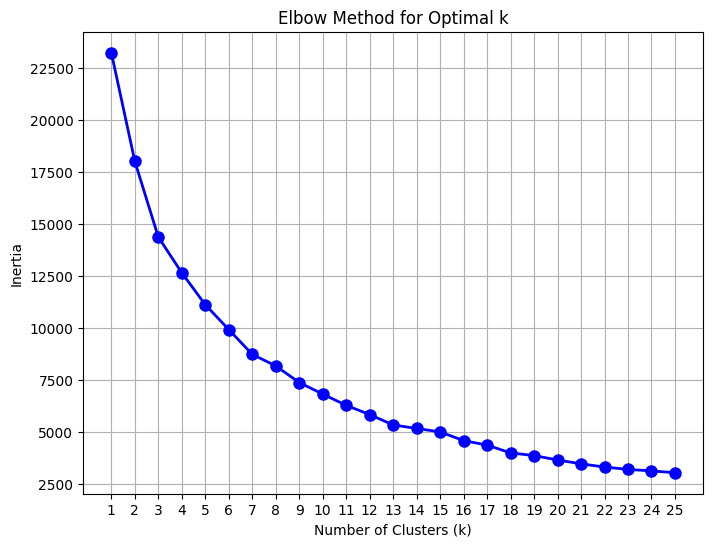

In [91]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

inertia = []
possible_k_values = range(1, 26)  # You can adjust the range of k values as needed

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(possible_k_values, inertia, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(np.arange(1, 26, 1))  # Adjust the x-axis ticks based on your range of k values
plt.grid(True)
plt.show()

In [130]:
from sklearn.cluster import KMeans, AgglomerativeClustering
clusters = 7

# Perform KMeans clustering
kmeans = KMeans(n_clusters=clusters, n_init='auto', random_state=42)
kmeans_clusters = kmeans.fit_predict(cluster_scaled)
cluster_info['kmeans_cluster'] = kmeans_clusters

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=clusters)
agglomerative_clusters = agglomerative.fit_predict(cluster_scaled)
cluster_info['agglomerative_cluster'] = agglomerative_clusters

In [131]:
cluster_of_clusters_info_kmeans = cluster_info.drop(["agglomerative_cluster"], axis=1).groupby('kmeans_cluster').agg('mean')
cluster_of_clusters_info_kmeans

,num_of_accidents,at_intersection,total_vehicles,avg_vehicles,average_days_ago,avg_accident_time
kmeans_cluster,,,,,,
0,1.425926,0.025464,2.179398,1.541071,707.140046,75679.444444
1,56.888889,0.639299,120.555556,2.112018,660.333333,47687.814815
2,2.619914,0.884642,4.982869,1.879681,683.554604,11463.743041
3,2.452711,0.889882,4.591425,1.855333,707.248424,74409.424968
4,1.431818,0.036357,2.066667,1.427489,837.719697,10487.107576
5,1.482185,0.049323,3.703088,2.586974,490.731591,20444.501188
6,21.412791,0.674703,42.877907,2.016327,649.656977,41592.866279


In [132]:
cluster_of_clusters_info_agglo = cluster_info.drop(["kmeans_cluster"], axis=1).groupby('agglomerative_cluster').agg('mean')
cluster_of_clusters_info_agglo

,num_of_accidents,at_intersection,total_vehicles,avg_vehicles,average_days_ago,avg_accident_time
agglomerative_cluster,,,,,,
0,1.233236,0.001437,1.517493,1.236065,673.760933,64522.475219
1,1.168950,0.005758,2.687976,2.325622,933.987823,39493.718417
2,3.329302,0.833014,6.398140,1.884630,690.413023,11635.773023
3,2.644676,0.847264,4.893519,1.835063,703.123843,74477.373843
4,26.064000,0.686374,52.424000,2.022212,640.440000,52842.416000
5,64.470588,0.595710,137.823529,2.131019,662.823529,38846.588235
6,1.297539,0.008466,2.062640,1.604314,408.219239,10600.957494


In [133]:
cluster_info.to_csv("data/cluster_of_clusters_info.csv")